## M04_3_addressee_classification_MA
A script that attempts the classification of the nominal 'addressee' variable for using a range of algorithms implemented using scikit learn and ~~the SMaPP text classifier~~ pipeline. Before this, I generated addressee classifications for all tweets using the tweet-text-filtering method (see script M03.R). So, beyond generating the classifications in this script, I will also compare them to the ones obtained through filtering. 

NL, 21/07/20  
NL, 23/07/20 -- updated for massachussets  
NL, 06/10/20 -- updating because of formatting issues that became apparent much later. 

See also: M04_2, M04_3 --> both are also jupyter notebooks that execute the same code as here

In [1]:
import matplotlib.pyplot as plt
import random
import joblib

import sys
import logging
import json
import sklearn

import numpy as np
import pandas as pd

from pprint import pprint

### DATA IN

In [3]:
LABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/labelled_tweets/fmtd_with_metadata/"
UNLABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/located_users_tweets/with_mention_dummies/"
DATA_OUT = "/Users/nikloynes/Desktop/SENTIMENT/data/classifications_rerun/"

In [4]:
ma_df = pd.read_csv(LABELLED_TWEETS + 'massachussets.csv', dtype=str)

In [5]:
ma_unlabelled_df = pd.read_json(UNLABELLED_TWEETS + 'massachussets.json', dtype=str, lines=True)

In [10]:
from io import StringIO
col = ['id', 'addressee', 'text']
ma_df = ma_df[col]
ma_df = ma_df[pd.notnull(ma_df['text'])]
ma_df.columns = ['id', 'addressee', 'text']
ma_df['category_id'] = ma_df['addressee'].factorize()[0]
category_id_ma_df = ma_df[['addressee', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_ma_df.values)
id_to_category = dict(category_id_ma_df[['category_id', 'addressee']].values)
ma_df.head()

,id,addressee,text,category_id
0,703265502261547008,Bernie Sanders,RT @VictorDukes23: I feel what Bernie Sanders ...,0
1,702498647703953408,Bernie Sanders,How will this get any of @BernieSanders ideas ...,0
2,704452664818601984,both,RT @UMassAmherst: New #WBZ - #UMass Amherst po...,1
3,702594375084318720,Bernie Sanders,RT @avxlanche: if you turn the lights off &amp...,0
4,701183764911812608,Hillary Clinton,RT @ParksPics: Like for Hillary Clinton\nRT fo...,2


## THE CATEGORY IDS ARE: 
**Bernie: 0  
both: 1  
Hillary: 2  
neither: 3**

**again, different from NH and SC**

In [11]:
ma_df.category_id.unique()

array([0, 1, 2, 3])

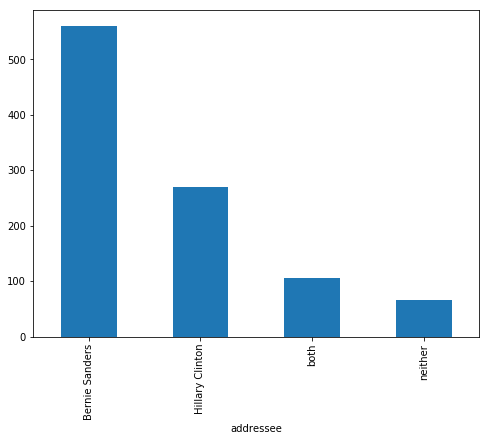

In [12]:
fig = plt.figure(figsize=(8,6))
ma_df.groupby('addressee').text.count().plot.bar(ylim=0)
plt.show()

# classes are unbalanced!!!
# this here is more like new hampshire again, quite dominant for bernie. 

#### Upsampling all response categories

As shown in the bar plot above, the 4 classes (Bernie, Hillary, both, neither) are unbalanced in the training data. While there is no guarantee that this is the best thing to do in such a case, it makes sense to create an upsampled dataset in which all response categories are equally prevalent.

In [13]:
ma_df.category_id.value_counts()

0    560
2    270
1    105
3     66
Name: category_id, dtype: int64

In [14]:
train_zero = ma_df[ma_df.category_id==0]
train_one = ma_df[ma_df.category_id==1]
train_two = ma_df[ma_df.category_id==2]
train_three = ma_df[ma_df.category_id==3]

train_one_upsampled = sklearn.utils.resample(train_one,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_two_upsampled = sklearn.utils.resample(train_two,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_three_upsampled = sklearn.utils.resample(train_three,
                                 replace=True, 
                                 n_samples=len(train_zero),
                                 random_state=123)

ma_upsampled_df = pd.concat([train_zero, train_one_upsampled, train_two_upsampled, train_three_upsampled])
ma_upsampled_df['category_id'].value_counts()

3    560
1    560
2    560
0    560
Name: category_id, dtype: int64

#### Vectorising the data to tf-idf

Sklearn can't learn the relationship between texts and labels directly -- first, the text needs to be transformed to a numerical representation. The below cell does this using the tf-ids method (term frequency, inverse document frequency). This method is likely superior to the simple 'bag of words' (term frequency) model, as it not only takes into account the frequency of a given term within a document (tweet), but also how it is relatively differenlty likely to appear in a given document. This helps the classifier decide on the correct class for a given tweet.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(ma_upsampled_df.text)
labels = ma_upsampled_df.category_id
features.shape

(2240, 2584)

#### Exploratory metrics: Most correlated n-grams / training labels

In [16]:
from sklearn.feature_selection import chi2
N = 2

for addressee, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(addressee))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bernie Sanders':
  . Most correlated unigrams:
. bernie
. berniesanders
  . Most correlated bigrams:
. berniesanders https
. bernie sanders
# 'Hillary Clinton':
  . Most correlated unigrams:
. clinton
. hillary
  . Most correlated bigrams:
. clinton https
. hillary clinton
# 'both':
  . Most correlated unigrams:
. poll
. tedcruz
  . Most correlated bigrams:
. realdonaldtrump hillaryclinton
. hillaryclinton berniesanders
# 'neither':
  . Most correlated unigrams:
. dknvm7wb
. plans
  . Most correlated bigrams:
. challenges need
. https dknvm7wb


#### Instantiating the data for training

In this step, the training data gets transformed into the right format and split, so that multiple algorithms can be applied to learning the connection between features and labels. For this purpose, I test:

- Naive Bayes
- SVM
- Random Forest
- Logistic Regression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(ma_upsampled_df['text'],  ma_upsampled_df['addressee'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


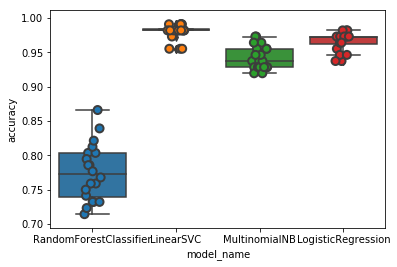

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.979911
LogisticRegression        0.966071
MultinomialNB             0.942857
RandomForestClassifier    0.775000
Name: accuracy, dtype: float64

#### It appears that SVM is the best model for this task. Now, to tune the hyper-parameters.

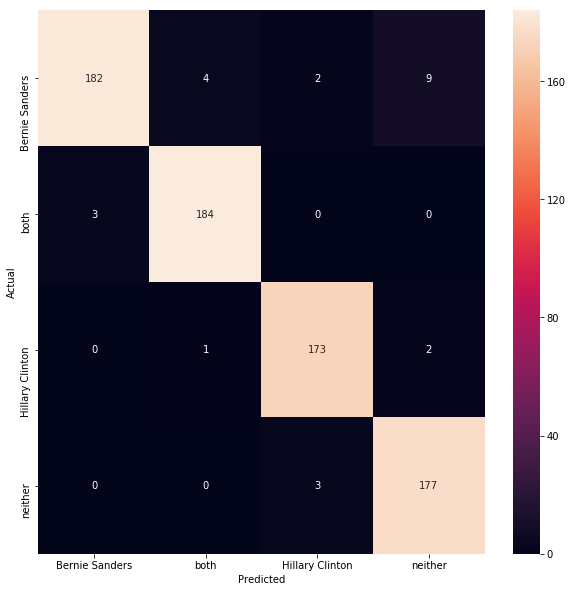

In [20]:
from sklearn.svm import SVC

# new model that incorporates probabilities. this might help decide which label to choose when 
# filtering-derived and ML-derived classifications are different.
model = SVC(kernel='linear', probability=True, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, ma_upsampled_df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_ma_df.addressee.values, yticklabels=category_id_ma_df.addressee.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The 'get_params()' method on the classifier object tells us which hyper-parameters were selected for this model. This allows us to tune the parameters using k-fold cross-validation. This is implemented using the 'GridSearchCV' method, using different tuning parameters defined in 'param_grid' 

In [21]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [22]:
param_grid = {'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter' : [1000, 10000, 100000]}

In [23]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(cv=10,estimator=model, param_grid=param_grid)
clf.fit(features, labels)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter': [1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### The most accurate/predictive model is chosen using the 'best_estimator' attribute on the cross-validation object.

In [24]:
final_model = clf.best_estimator_
final_model

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=1000, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
final_model.fit(X_train, y_train)
final_model_preds = final_model.predict(X_test)

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, final_model_preds, target_names=ma_df['addressee'].unique()))

                 precision    recall  f1-score   support

 Bernie Sanders       0.99      0.92      0.96       197
           both       0.95      0.99      0.97       187
Hillary Clinton       0.97      0.97      0.97       176
        neither       0.95      0.98      0.96       180

      micro avg       0.97      0.97      0.97       740
      macro avg       0.97      0.97      0.97       740
   weighted avg       0.97      0.97      0.97       740



## Now to apply the model on previously unseen data!

The previously unseen data is the 'nh_unlabelled_df' data frame. It needs to be slightly transformed first, including removal of columns that aren't relevant for this task. Also, the 'addressee' variable is transformed from the 'bernie_mention' and 'hillary_mention' variables, as these are dummies themselves, and not a 4-level categorical variable like the one we are looking to predict. The 'bernie_mention' and 'hillary_mention' variables come from the tweet text filtering approach taken in M_03.R.

In [27]:
col = ['id_str', 'text', 'bernie_mention', 'hillary_mention']
ma_unlabelled_df = ma_unlabelled_df[col]

In [28]:
ma_unlabelled_df['addressee'] = 'neither'
ma_unlabelled_df.loc[(ma_unlabelled_df.bernie_mention=='True') & (ma_unlabelled_df.hillary_mention=='True'), 'addressee'] = 'both'
ma_unlabelled_df.loc[(ma_unlabelled_df.bernie_mention=='True') & (ma_unlabelled_df.hillary_mention=='False'), 'addressee'] = 'Bernie Sanders'
ma_unlabelled_df.loc[(ma_unlabelled_df.bernie_mention=='False') & (ma_unlabelled_df.hillary_mention=='True'), 'addressee'] = 'Hillary Clinton'
ma_unlabelled_df = ma_unlabelled_df[pd.notnull(ma_unlabelled_df['text'])]

In [29]:
# what does the naive mention classification say about distribution of mentions by candidate?
# let' see how it compares to the classified values.
ma_unlabelled_df.addressee.value_counts()

Bernie Sanders     49596
Hillary Clinton    26098
both               16410
Name: addressee, dtype: int64

In [30]:
features_unseen = tfidf.transform(ma_unlabelled_df.text)
features_unseen.shape

(92104, 2584)

In [31]:
# make prediction on new data
preds_unseen_data = final_model.predict(features_unseen)
probs_unseen_data = final_model.predict_proba(features_unseen)

In [32]:
class_probabilites_df = pd.DataFrame(data=probs_unseen_data)
class_probabilites_df.columns = ['class_0', 'class_1', 'class_2', 'class_3']
class_probabilites_df = class_probabilites_df.round(decimals=3)

In [33]:
ma_unlabelled_df['preds_addressee'] = preds_unseen_data 
ma_unlabelled_df = pd.concat([ma_unlabelled_df, class_probabilites_df], axis=1)

In [34]:
ma_unlabelled_df

,id_str,text,bernie_mention,hillary_mention,addressee,preds_addressee,class_0,class_1,class_2,class_3
0,697270192070664193,"RT @BernieSanders: When we stand together, we ...",True,False,Bernie Sanders,0,0.994,0.002,0.001,0.004
1,697270324627308544,CFYW salutes @BernieSanders! If he goes all th...,True,False,Bernie Sanders,0,0.960,0.024,0.003,0.013
2,697270477744640004,@realDonaldTrump You are such a bullshit artis...,True,False,Bernie Sanders,1,0.235,0.756,0.007,0.002
3,697270706661416963,@BernieSanders \nIf minimum wage would've rise...,True,False,Bernie Sanders,0,0.982,0.005,0.003,0.011
4,697270801763069952,"RT @billmon1: 73%!in. Votes:\nSanders: 102,651...",True,False,Bernie Sanders,1,0.187,0.746,0.018,0.049
5,697271008273813506,"RT @People4Bernie: Together, WE will win. #Fee...",True,False,Bernie Sanders,0,0.625,0.030,0.052,0.293
6,697271379952066560,RT @TrueStoryShaff: SANDERS SOARS: A Democrati...,True,False,Bernie Sanders,0,0.931,0.010,0.009,0.050
7,697271458754596868,RT @MMFlint: Here's pretty much all you need t...,True,False,Bernie Sanders,0,0.989,0.003,0.000,0.008
8,697271539901845504,We won pub trivia tonight with a Bernie Sander...,True,False,Bernie Sanders,0,0.973,0.009,0.008,0.011
9,697271543924133888,"RT @BernieSanders: When we stand together, we ...",True,False,Bernie Sanders,0,0.994,0.002,0.001,0.004


In [36]:
# writing out nh_unlabelled_df to a csv file
#ma_unlabelled_df.to_csv(DATA_OUT+'ma_addressee_classified.csv', index=False)
# doing json instead because this didn't work

In [35]:
ma_unlabelled_df.to_json(DATA_OUT+'ma_addressee_classified.json', orient='records', lines=True)

In [36]:
ma_unlabelled_df.preds_addressee.value_counts()

0    50176
2    28228
1    11793
3     1907
Name: preds_addressee, dtype: int64

In [37]:
ma_unlabelled_df.addressee.value_counts()

Bernie Sanders     49596
Hillary Clinton    26098
both               16410
Name: addressee, dtype: int64